In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

model_name = 'facebook/opt-6.7b'
device = "cuda"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
testenc = tokenizer("\n\n".join(dataset["text"]), return_tensors="pt")

/home/jwjeong/anaconda3/envs/autogptq/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


In [36]:
model.model.decoder.layers[0].fc2.weight.size()

torch.Size([4096, 16384])

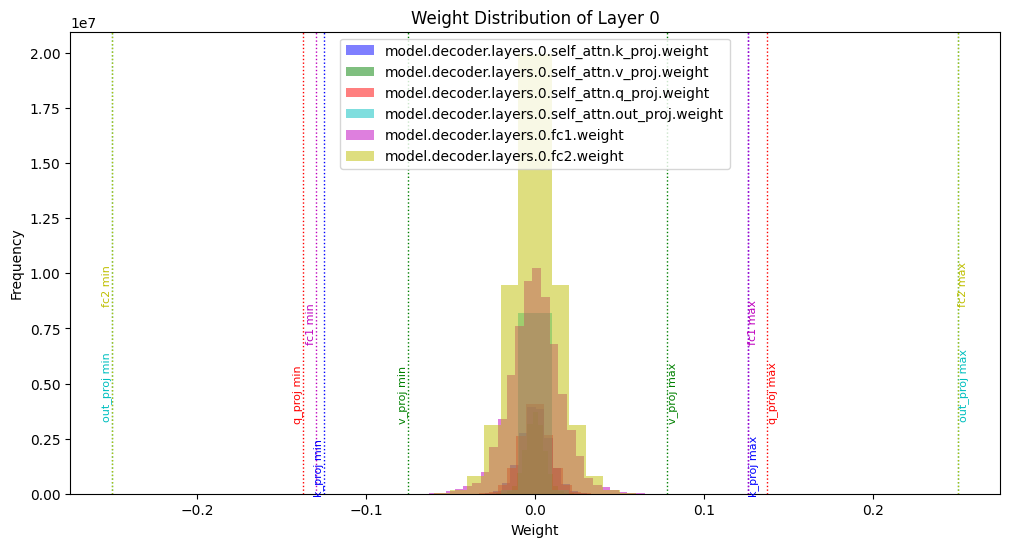

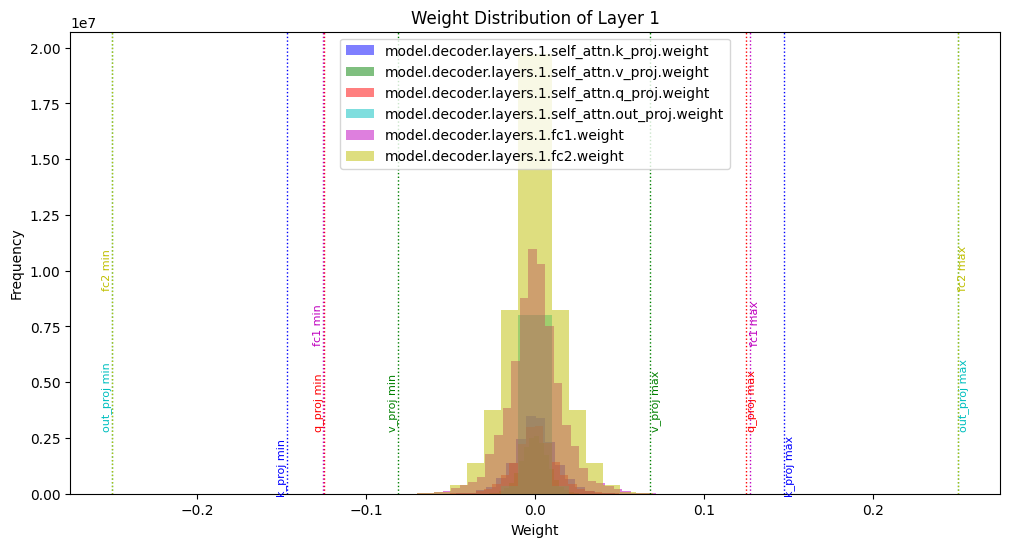

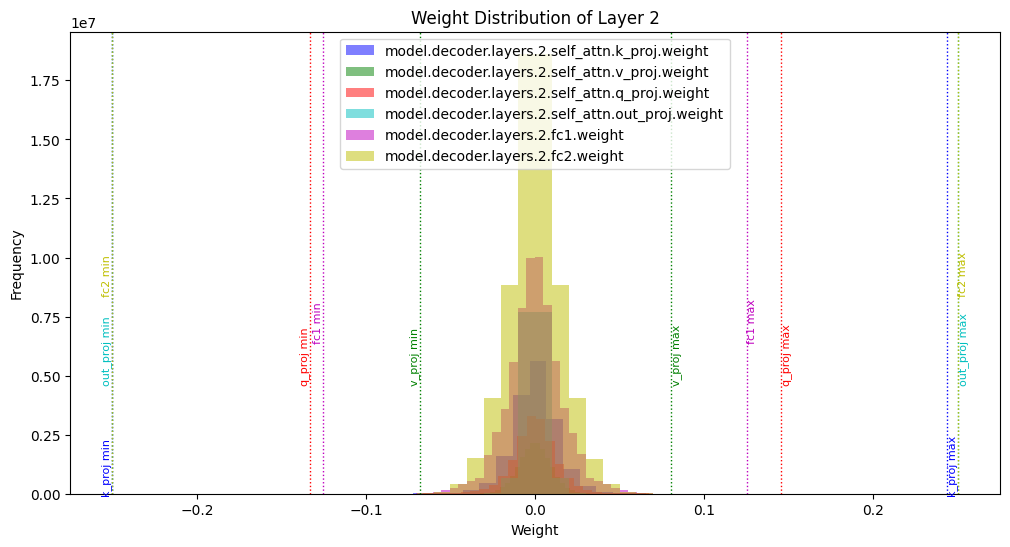

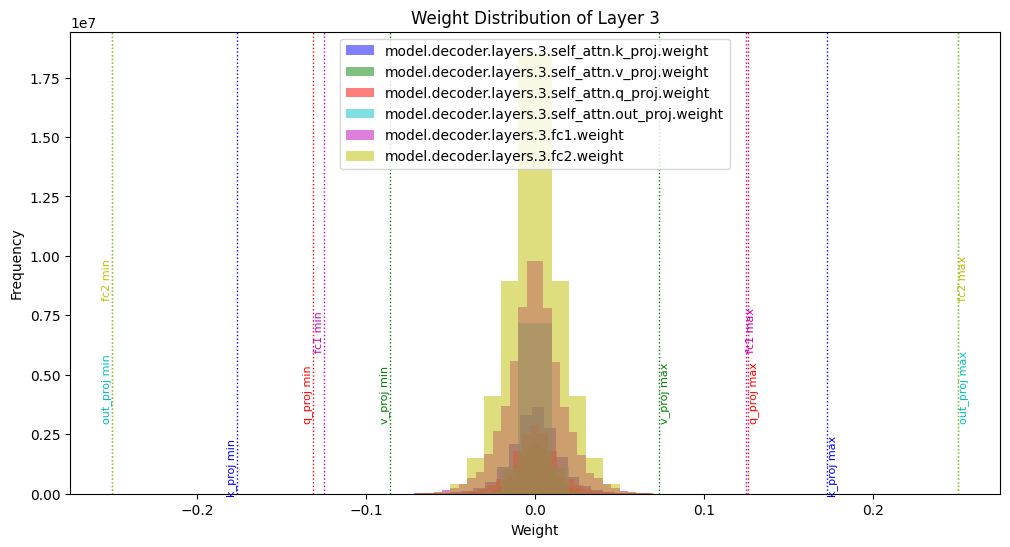

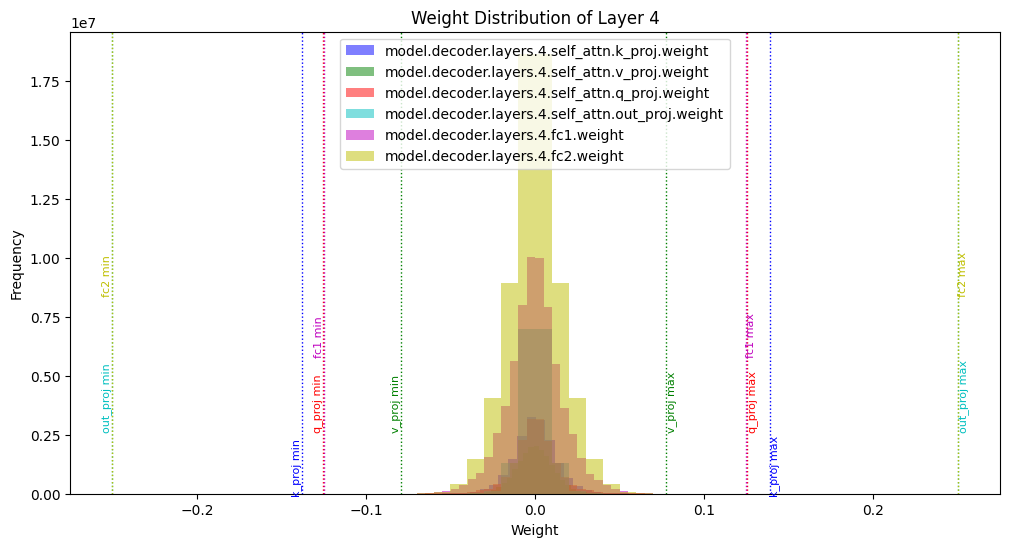

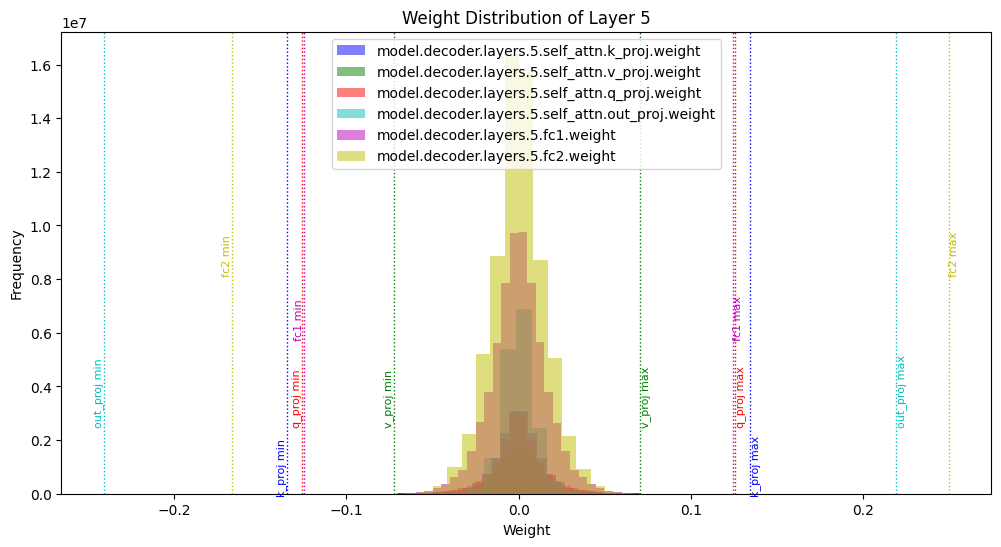

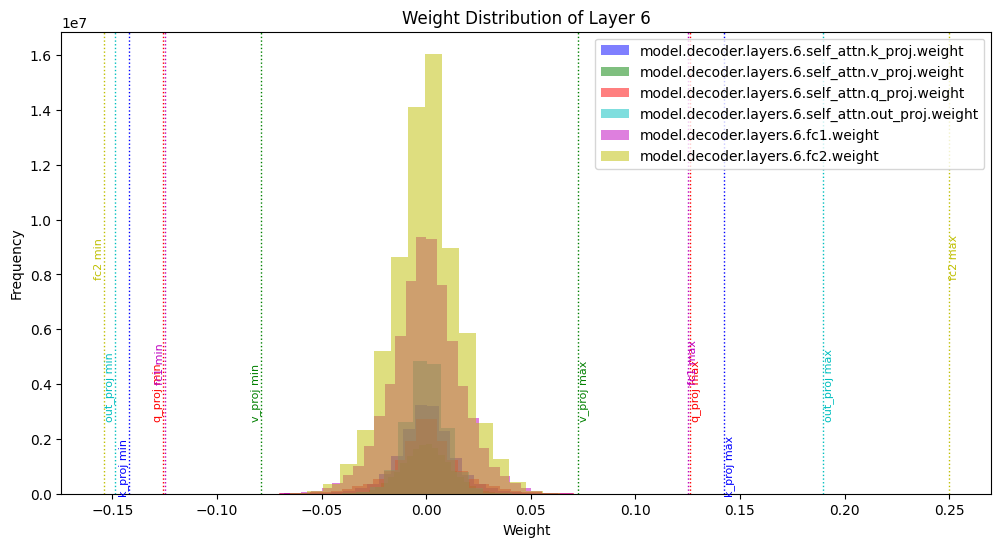

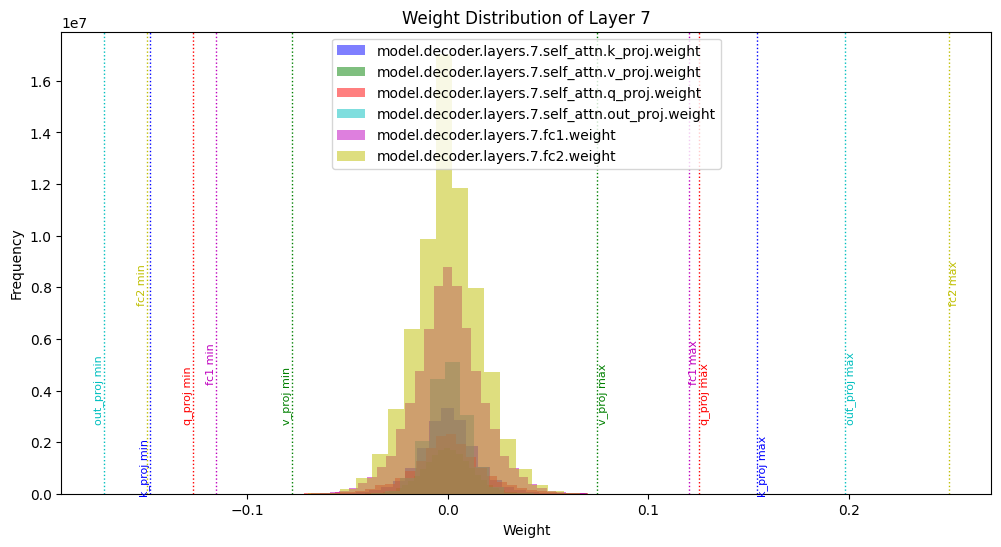

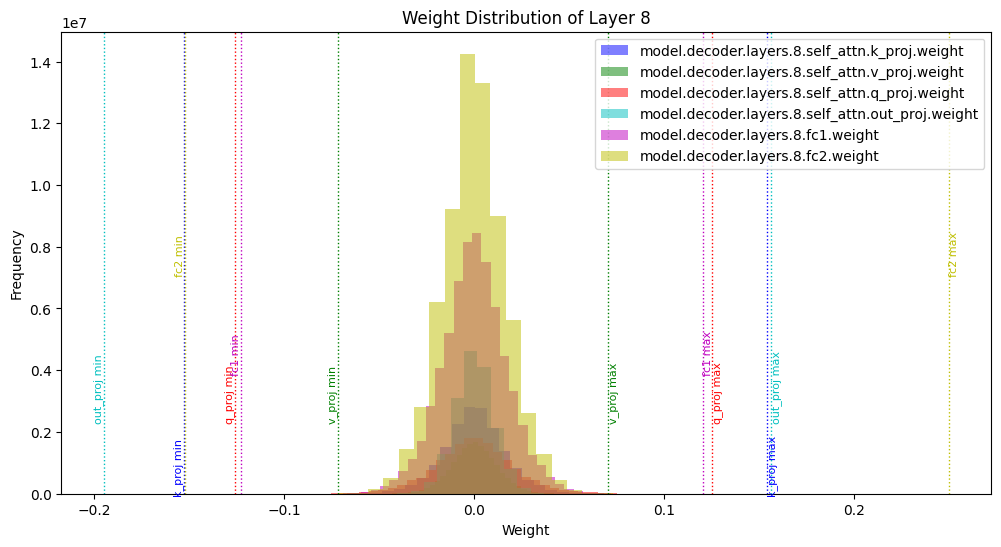

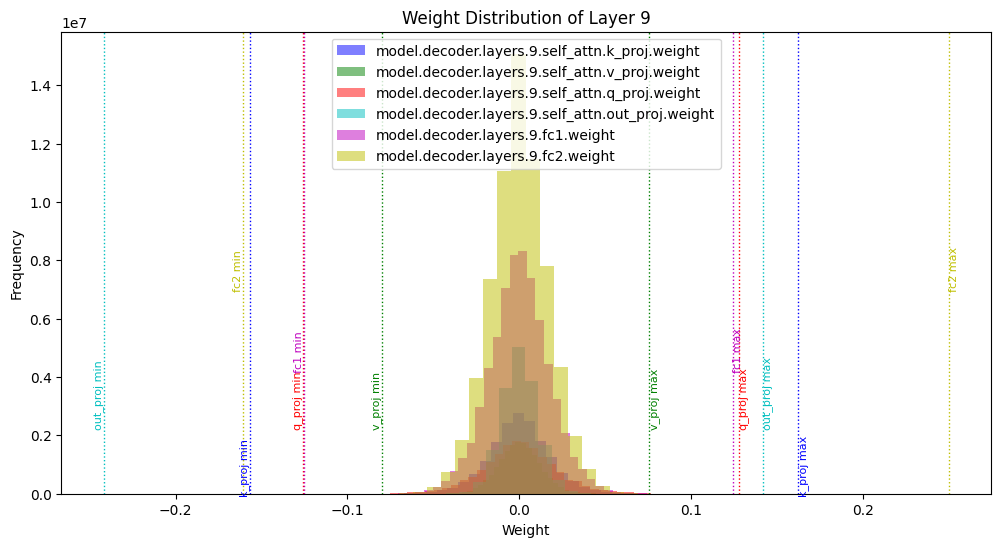

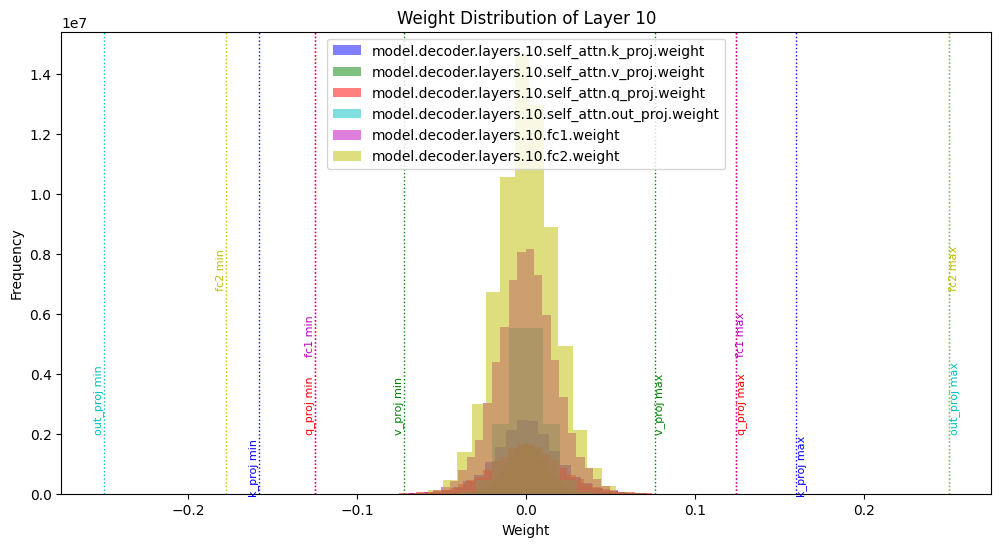

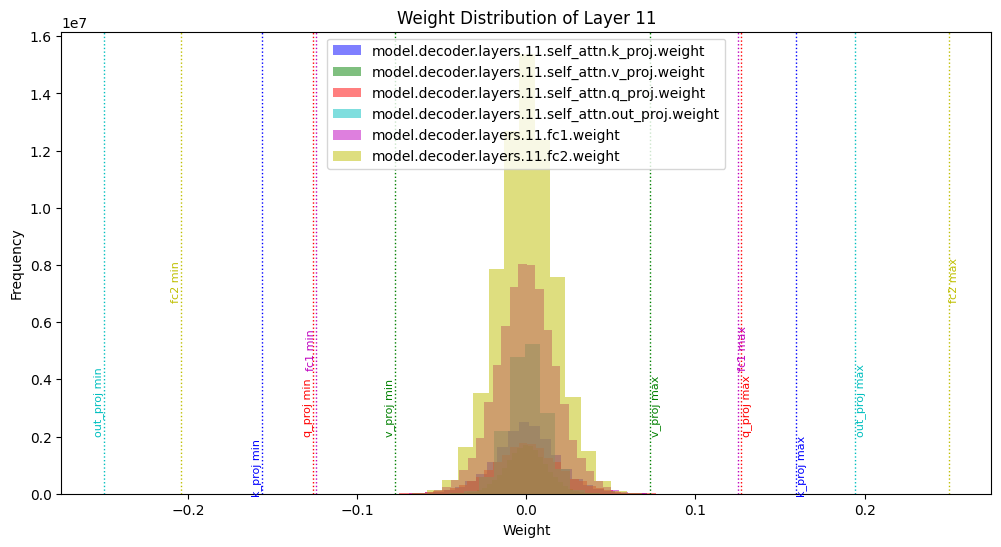

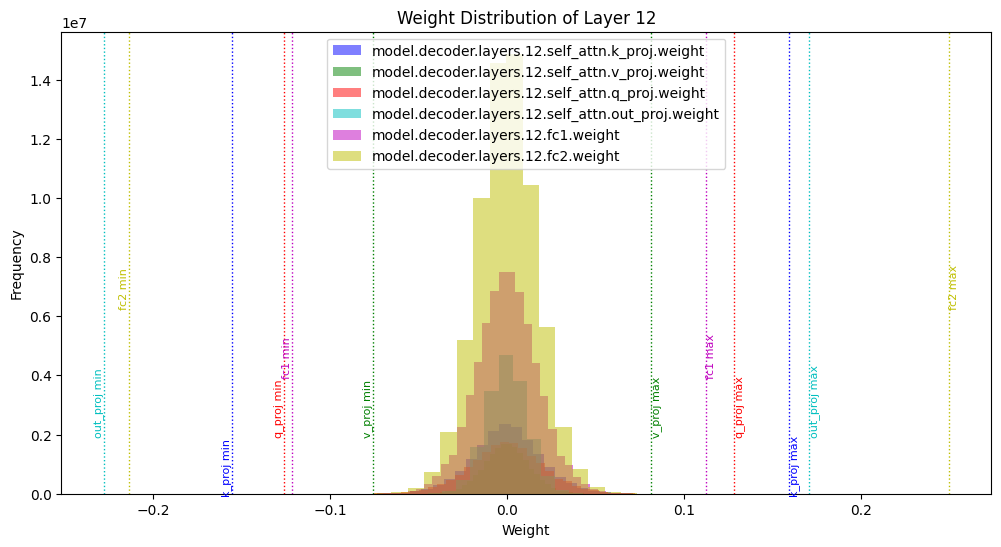

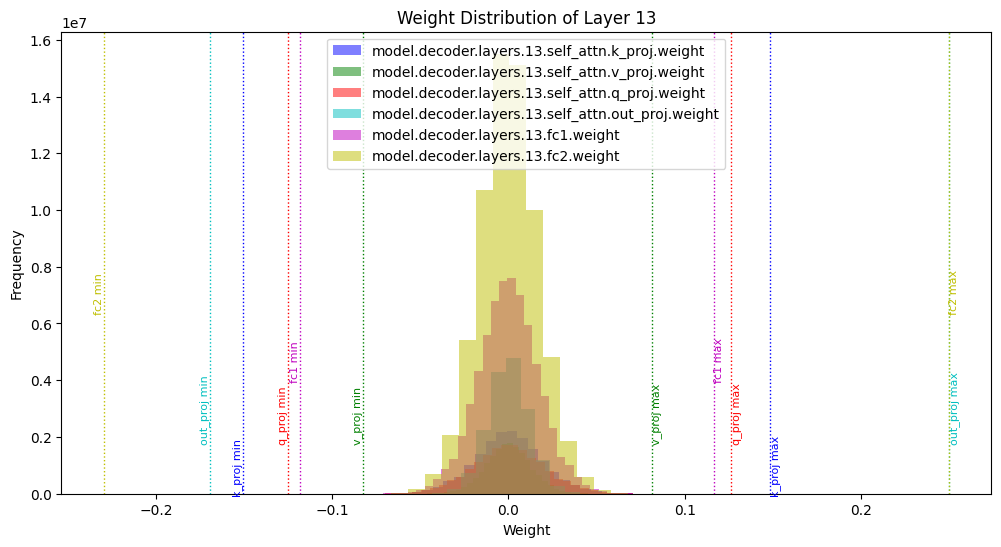

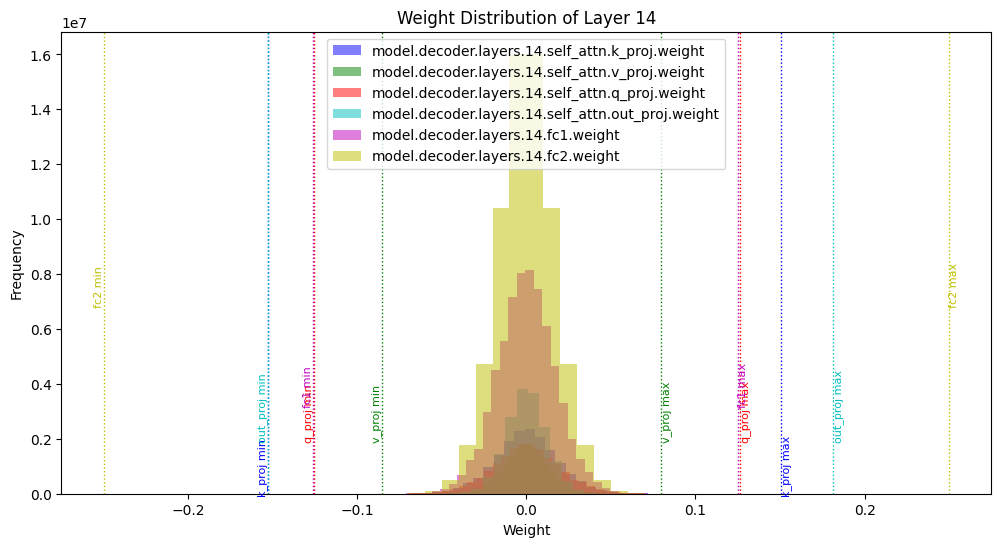

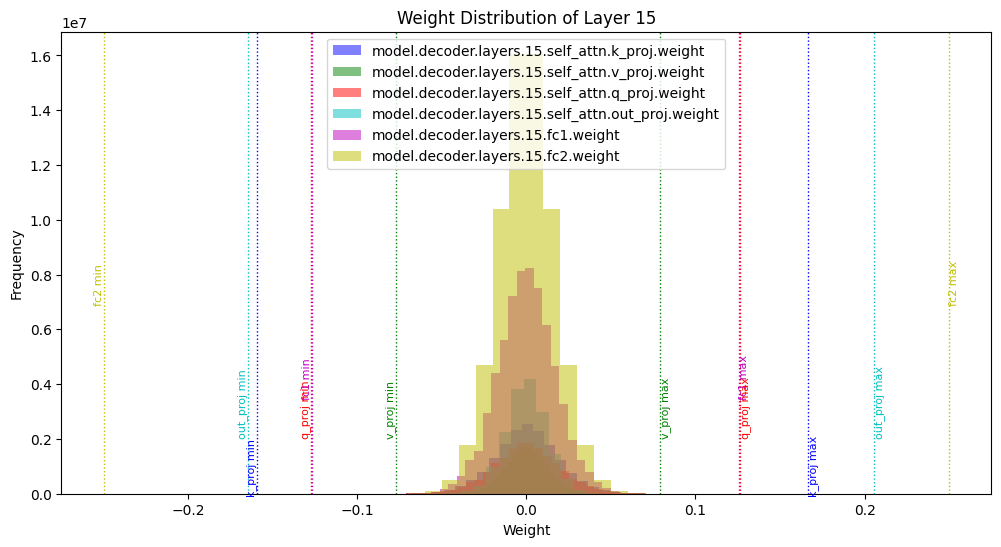

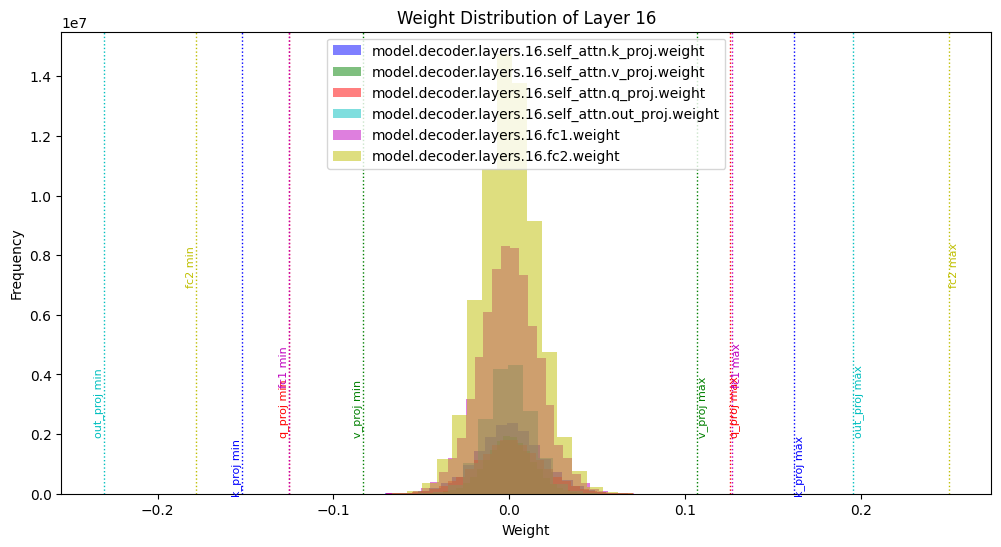

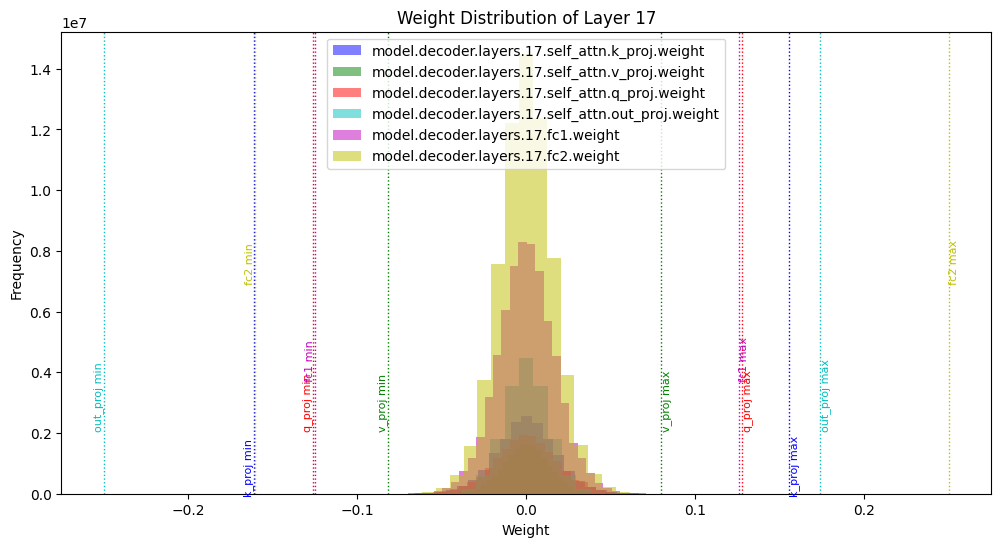

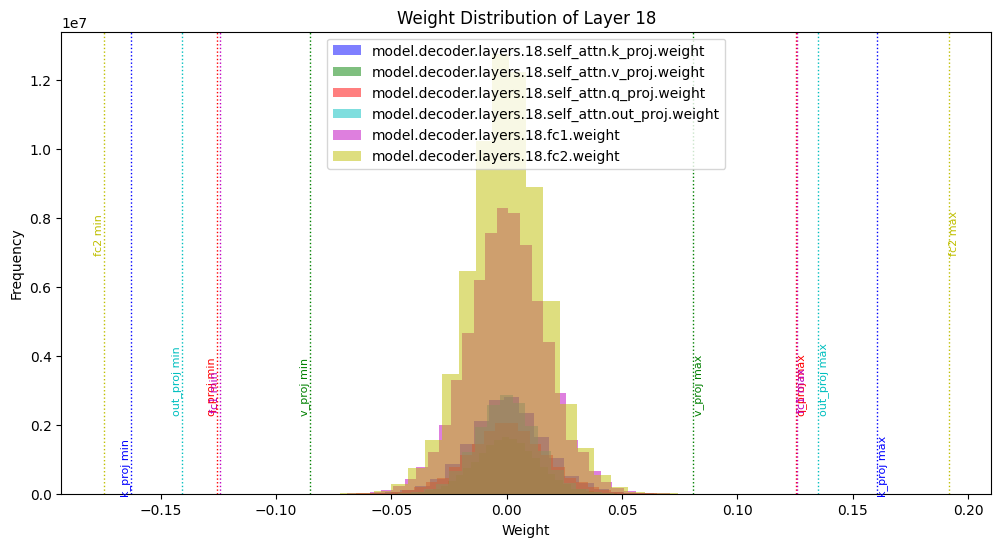

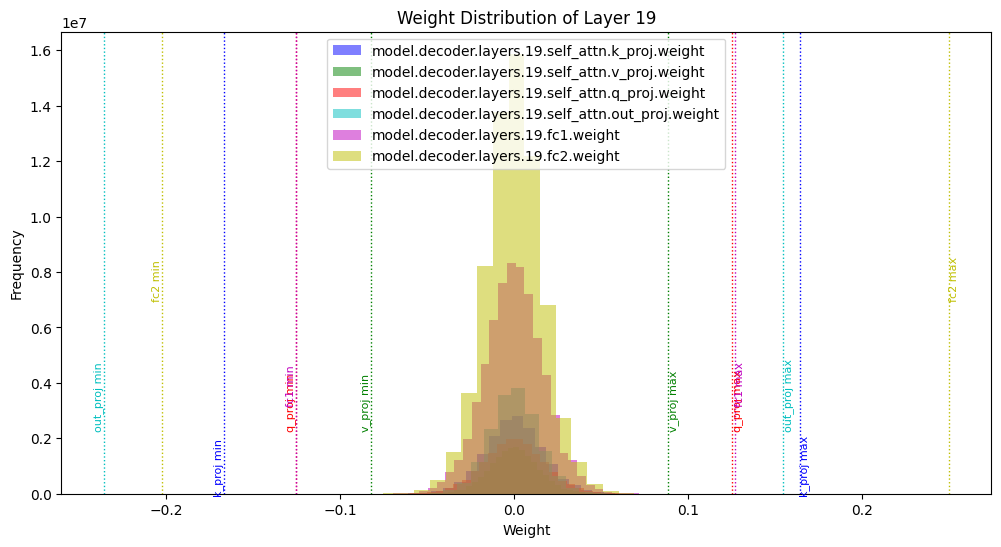

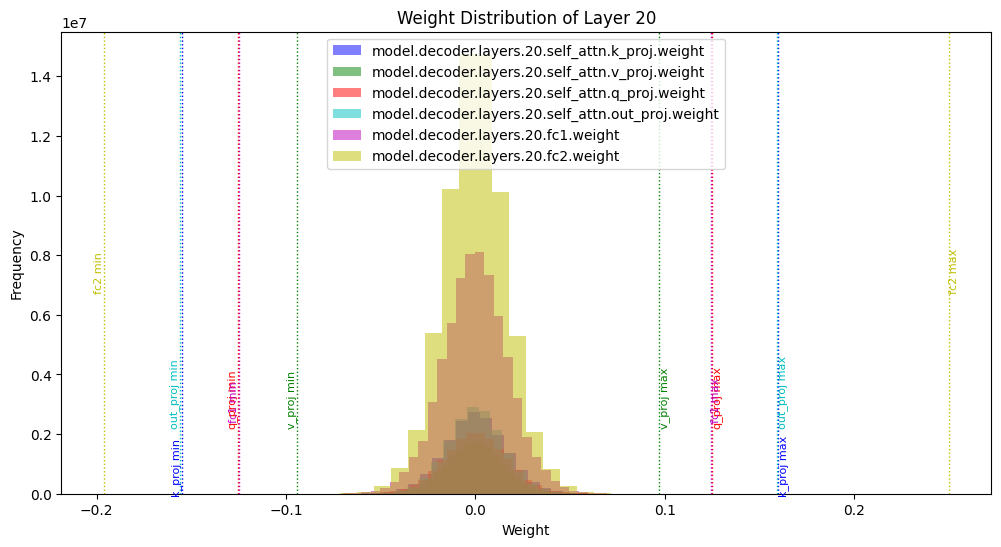

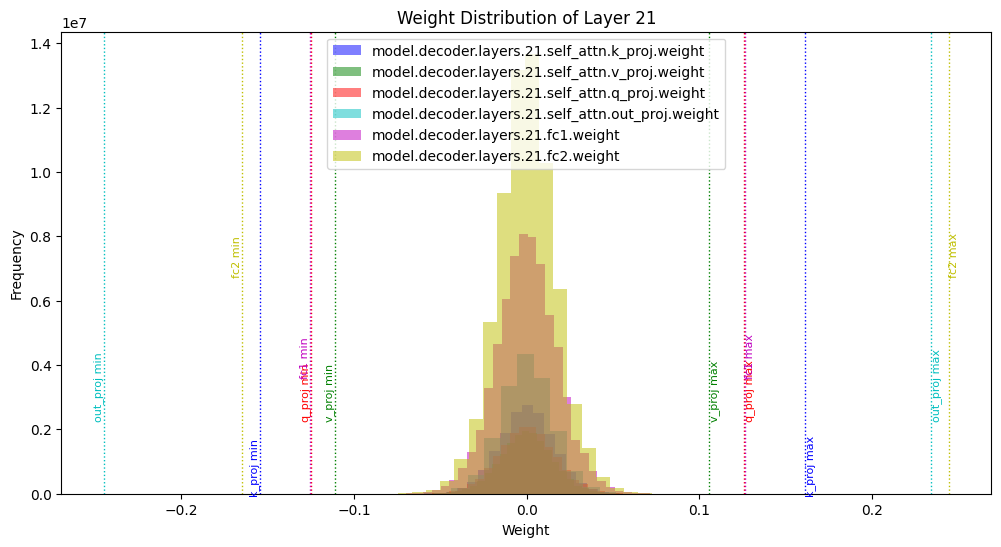

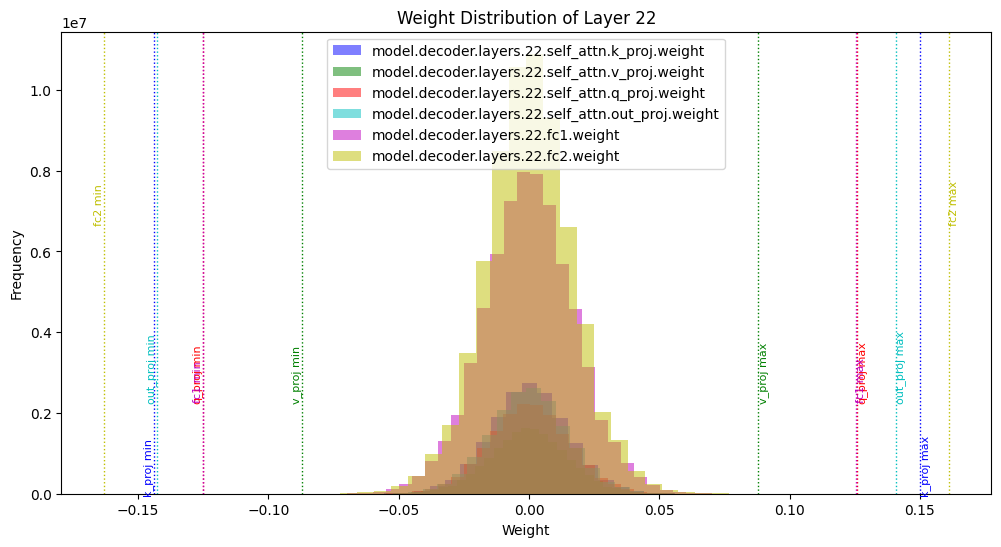

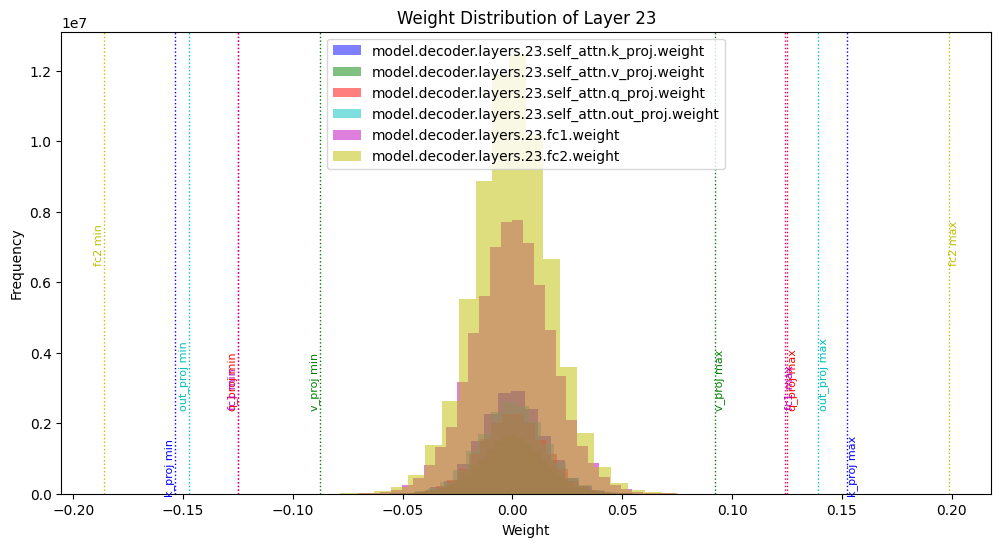

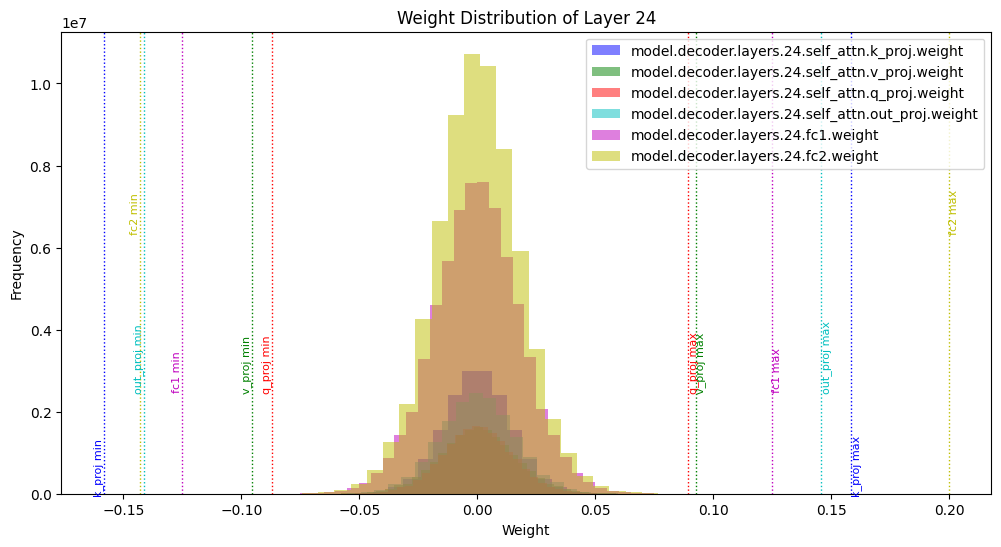

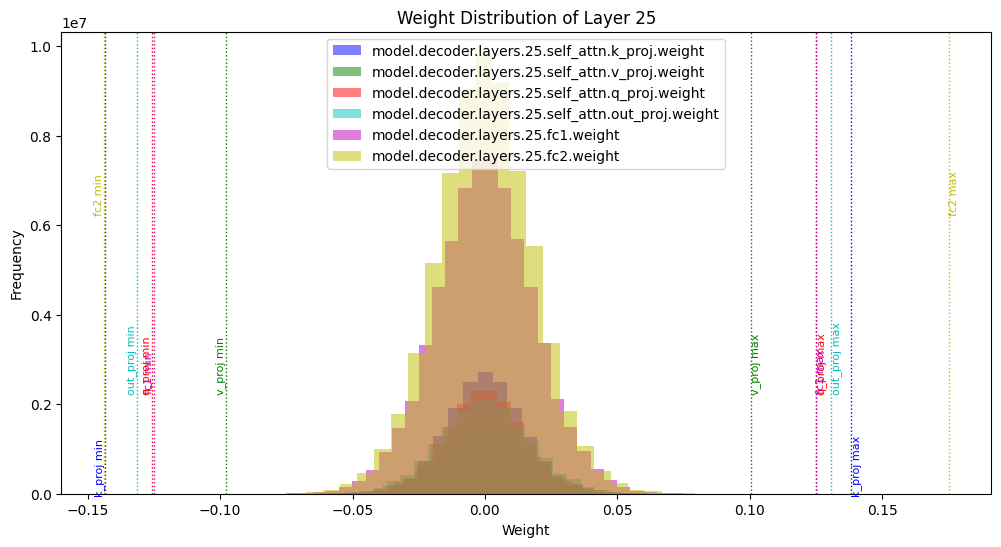

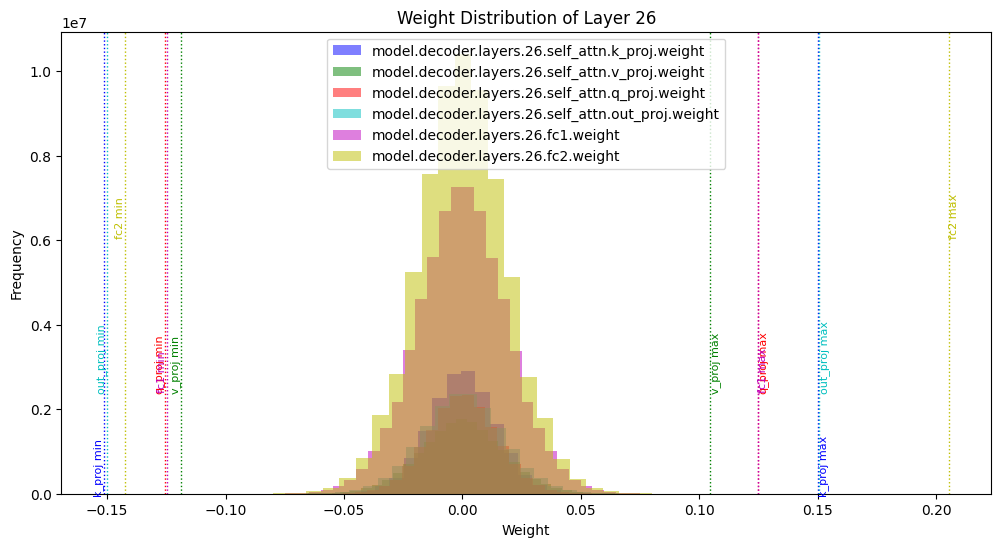

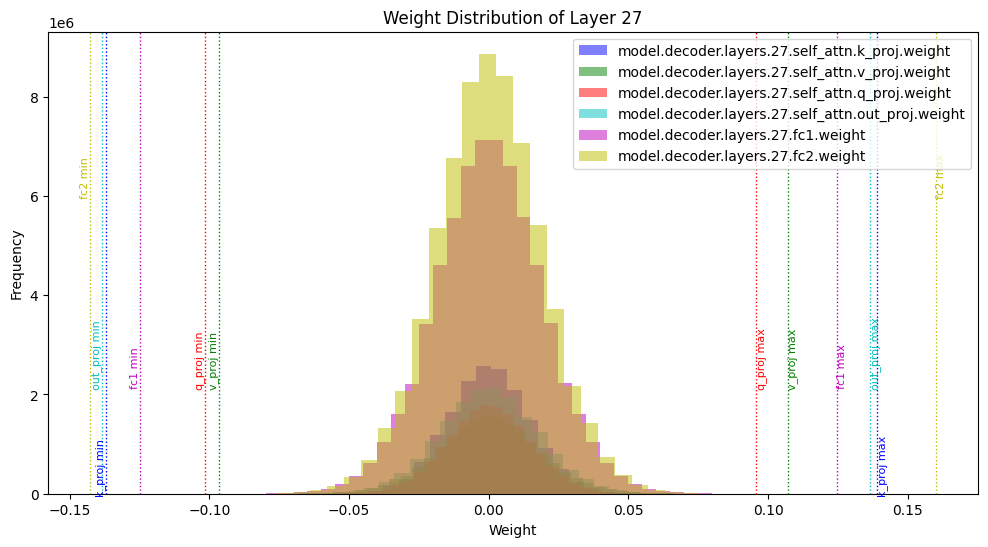

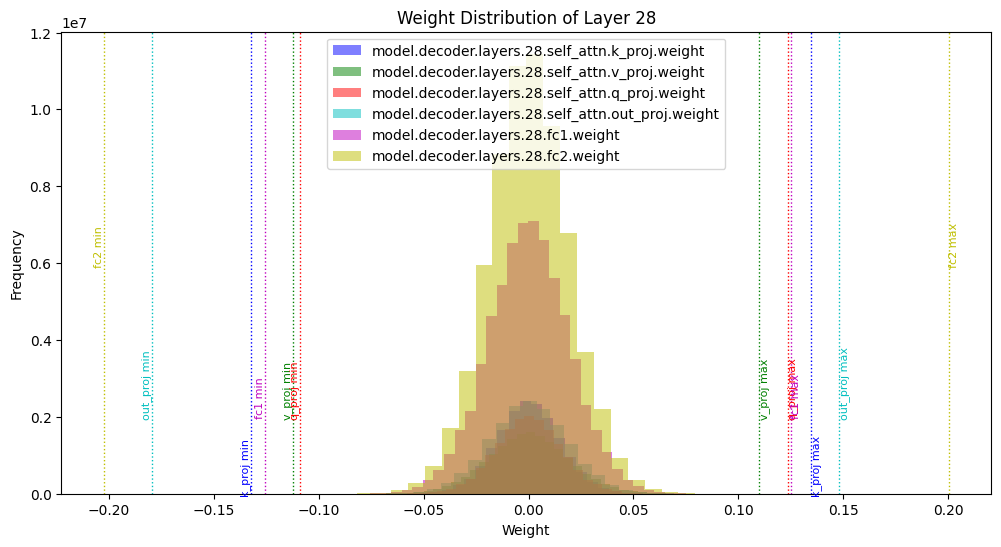

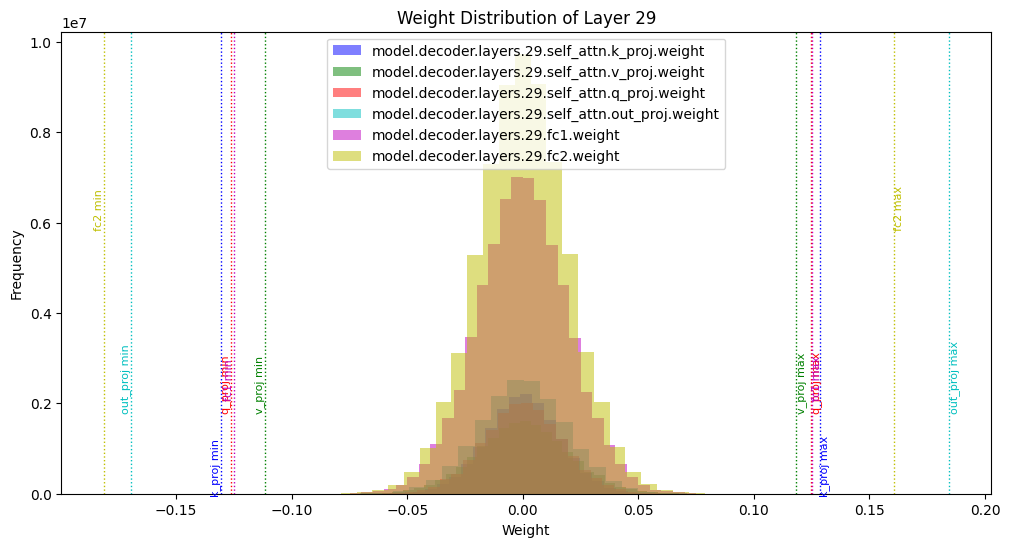

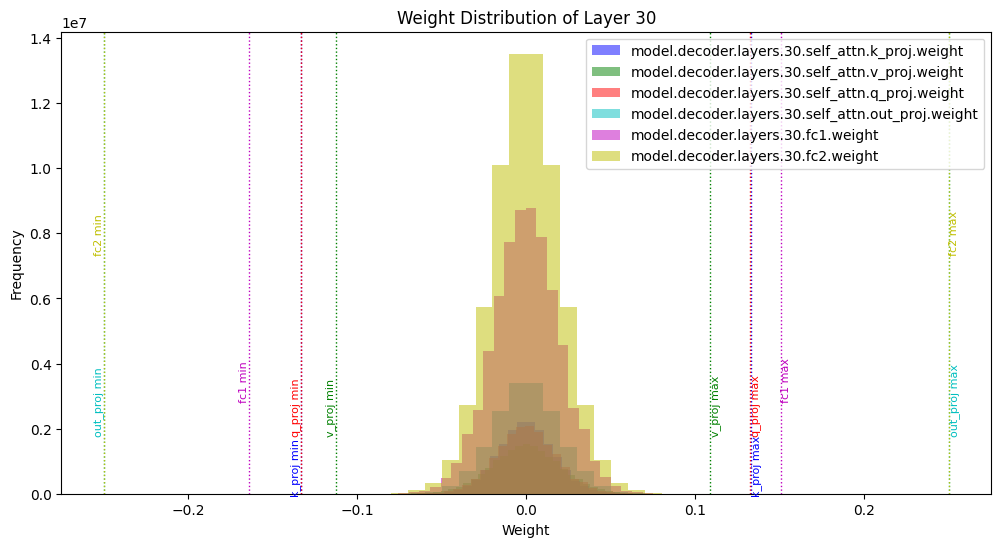

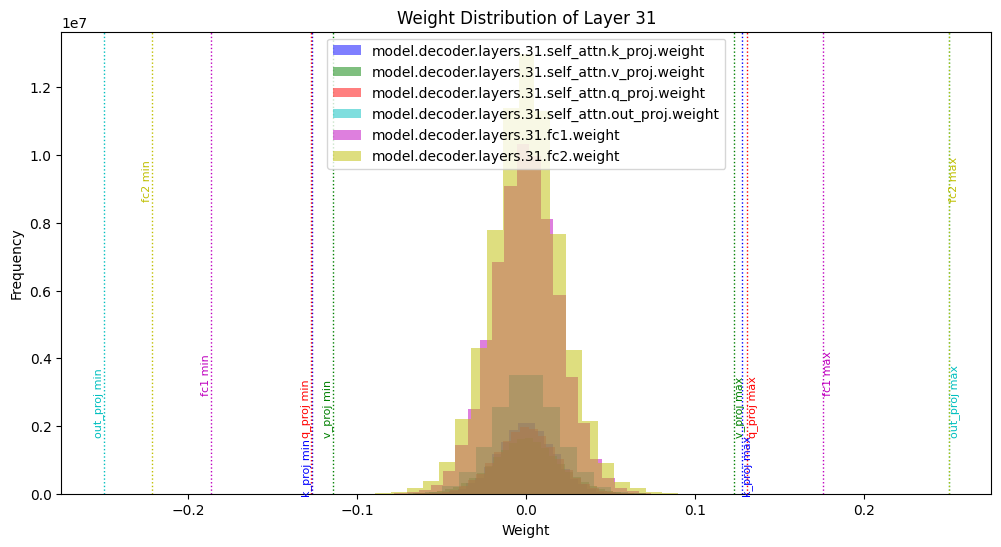

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def plot_layer_weights(model):
    param_names = ['k_proj', 'v_proj', 'q_proj', 'out_proj', 'fc1', 'fc2']
    color_list = ['b', 'g', 'r', 'c', 'm', 'y']  # 색상 리스트

    # 모델의 모든 파라미터에 대해 반복
    for layer_idx in range(len(model.model.decoder.layers)):
        plt.figure(figsize=(12, 6))
        for param_name_idx, param_name in enumerate(param_names):
            matched = False
            for name, param in model.named_parameters():
                if f"model.decoder.layers.{layer_idx}.self_attn.{param_name}.weight" in name or \
                   f"model.decoder.layers.{layer_idx}.{param_name}.weight" in name:
                    # 가중치 데이터 추출
                    weights = param.data.cpu().numpy()
                    
                    weight_min = weights.min()
                    weight_max = weights.max()
                    
                    color = color_list[param_name_idx % len(color_list)]
                    
                    plt.axvline(weight_min, color=color, linestyle='dotted', linewidth=1)
                    plt.axvline(weight_max, color=color, linestyle='dotted', linewidth=1)
                    
                    plt.text(weight_min, plt.ylim()[1]*0.8, f'{param_name} min', color=color, fontsize=8, ha='right', rotation=90)
                    plt.text(weight_max, plt.ylim()[1]*0.8, f'{param_name} max', color=color, fontsize=8, ha='left', rotation=90)
                    # 가중치 분포 그리기
                    plt.hist(weights.flatten(), bins=50, alpha=0.5, label=name, color=color)
                    matched = True
                    break

            if not matched:
                print(f"No match found for {param_name} in layer {layer_idx}")

        plt.title(f'Weight Distribution of Layer {layer_idx}')
        plt.xlabel('Weight')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

# 가중치 분포 시각화 함수 호출
plot_layer_weights(model)